<a href="https://colab.research.google.com/github/vahid-khazaei-nezhad/Data_Science_homework/blob/main/My_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installed libraires

In [ ]:
pip install plot_keras_history;
pip install keras.utils;
pip install keras_tuner;
pip install graphviz;
pip install pydot;

# Importing Libraries

In [ ]:
import numpy as np

import cv2

#from keras import regularizers
from keras.models import Sequential
#from keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from keras_tuner import HyperParameters, BayesianOptimization
from keras import Input

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from plot_keras_history import show_history, plot_history

print('Libraries imported successfully')

Libraries imported successfully


# Loading dataset

In [ ]:
data = np.load('mnist_2digits_10K.npy') 

labels = np.load('mnist_2digits_10K_labels.npy')

# Cheking the dataset shape, dtype

In [ ]:
data.shape

(10000, 32, 32)

In [ ]:
data.dtype

dtype('float32')

In [ ]:
np.max(data), np.min(data)

(1.0, 0.0)

# Visualizing a sample from dataset with its label

# Doing Machine Learning (CNN)

## Concatening labels(two columns) into one target column

In [ ]:
target_map = dict()

combined_labels = [sorted([l[0] ,l[1]]) for l in labels]

combined_labels = [str(l[0]) + str(l[1]) for l in combined_labels]

target_label = np.unique(combined_labels)

for index, value in enumerate(target_label):
    
    target_map[value] = index
    
##

combined_labels = [target_map[value] for value in combined_labels]

target = list(target_map)

## Splitting dataset into test & train with its labels

In [ ]:
test_percent = 0.1

number_of_classes = len(target)

data_length = len(data)

x_train = data[: -int(data_length * test_percent)]

y_train = combined_labels[: -int(data_length * test_percent) :]

x_test = data[-int(data_length * test_percent) :]

y_test = combined_labels[-int(data_length * test_percent) :]

y_train = to_categorical(y_train, num_classes= number_of_classes, dtype='float32')

y_test = to_categorical(y_test, num_classes= number_of_classes, dtype='float32')

print('Train: ', x_train.shape, end= ', labels: ')
print(y_train.shape)
print('Test:  ', x_test.shape, end= ', labels: ')
print(y_test.shape)

Train:  (9000, 32, 32), labels: (9000, 45)
Test:   (1000, 32, 32), labels: (1000, 45)


## Building CNN Model with keras tuner options

In [ ]:
def build_model(hp):
    
    number_of_classes = len(target)
    
    model = Sequential()
    
    model.add(
        Conv2D( 
               hp.Int("filters0", min_value= 32, max_value= 128, step= 8),
               (3, 3),
               input_shape= (32, 32, 1),
               activation= 'relu', 
               padding= hp.Choice('Padding0', ['same', 'valid'])
              )
    )
    
    model.add(MaxPooling2D(pool_size= (2, 2)))
    
    if hp.Boolean("batchNormalization"):

      model.add(BatchNormalization())
        
    for i in range(hp.Int("cnn_layers", min_value= 1, max_value= 2)):
                   
        model.add(
            Conv2D(
                    hp.Int(f"filters1_{i}", min_value= 32, max_value= 128, step= 8),
                    (3, 3),
                    activation= 'relu',
                    padding= hp.Choice('Padding1', ['same', 'valid'])
                 )
        )
        
        model.add(MaxPooling2D(pool_size= (2, 2)))
        
        if hp.Boolean(f"batchNormalization_{i}"):
            
            model.add(BatchNormalization())
        
        ###
    model.add(Flatten())
    
    num_of_layers = hp.Int('num_layers', min_value= 2, max_value= 5)
    
    for i in range(num_of_layers):
        
        model.add(
            
            Dense(
                
                units= hp.Int(f"units_{i}", min_value= 1024, max_value= 4096, step= 1024),
                
                activation= hp.Choice(f'activation2_{i}', ['relu', 'tanh', 'sigmoid']),
            )
        )
        
        drop_rate = hp.Float(f'dropout_value_{i}', min_value = 0.2, max_value= 0.5, sampling= "log")
    
        if hp.Boolean(f"dropout_{i}"):
                   
            model.add(Dropout(rate= drop_rate))
                   
    model.add(Dense(number_of_classes, activation= "softmax"))
                   
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2, sampling= "log")
    
    momentum = hp.Float("momentum", min_value= 0.7, max_value= 0.9, sampling= "log")
                   
    nesterov = hp.Boolean("nesterov")
    
    model.compile(
        
        optimizer=  optimizers.SGD(learning_rate= learning_rate, momentum= momentum, nesterov= nesterov),
        
        loss= "categorical_crossentropy",
        
        metrics= ["accuracy"],
    )
    
    print('# paramters: ', model.count_params())
    
    return model

## Tuning model

In [ ]:
tuner = BayesianOptimization(
                            build_model,
                            'val_loss',
                            1,
                            num_initial_points= 2,
                            alpha= 0.0001,
                            beta= 2.6,
                            seed= 23,
                            hyperparameters= HyperParameters(),
                            overwrite= True,
                            directory="\Tunning",
                            project_name="InaitTask",
                            )
###

#tuner.search_space_summary()

tuner.search(x_train, y_train, epochs= 5, validation_split= 0.2, verbose= 2)

Trial 1 Complete [00h 06m 21s]
val_loss: 2.1462581157684326

Best val_loss So Far: 2.1462581157684326
Total elapsed time: 00h 06m 21s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in \Tunning\InaitTask
Showing 10 best trials
Trial summary
Hyperparameters:
filters0: 120
Padding0: valid
batchNormalization: False
cnn_layers: 2
filters1_0: 96
Padding1: same
batchNormalization_0: True
num_layers: 4
units_0: 1024
activation2_0: relu
dropout_value_0: 0.33727681908678286
dropout_0: False
units_1: 3072
activation2_1: tanh
dropout_value_1: 0.37361723014039677
dropout_1: False
lr: 0.0016212546866636098
momentum: 0.7855112801148081
nesterov: False
filters1_1: 32
batchNormalization_1: False
units_2: 1024
activation2_2: relu
dropout_value_2: 0.2
dropout_2: False
units_3: 1024
activation2_3: relu
dropout_value_3: 0.2
dropout_3: False
Score: 2.1462581157684326


## Choose best model

In [ ]:
best_model = tuner.get_best_models()[0]

best_model.build(input_shape= (32, 32, 1))

best_model.summary()

# paramters:  7820253
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 120)       1200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 120)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 96)        103776    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 96)         0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 96)         384       
 ormalization)                                                   
                                  

## Visualize best model architecture

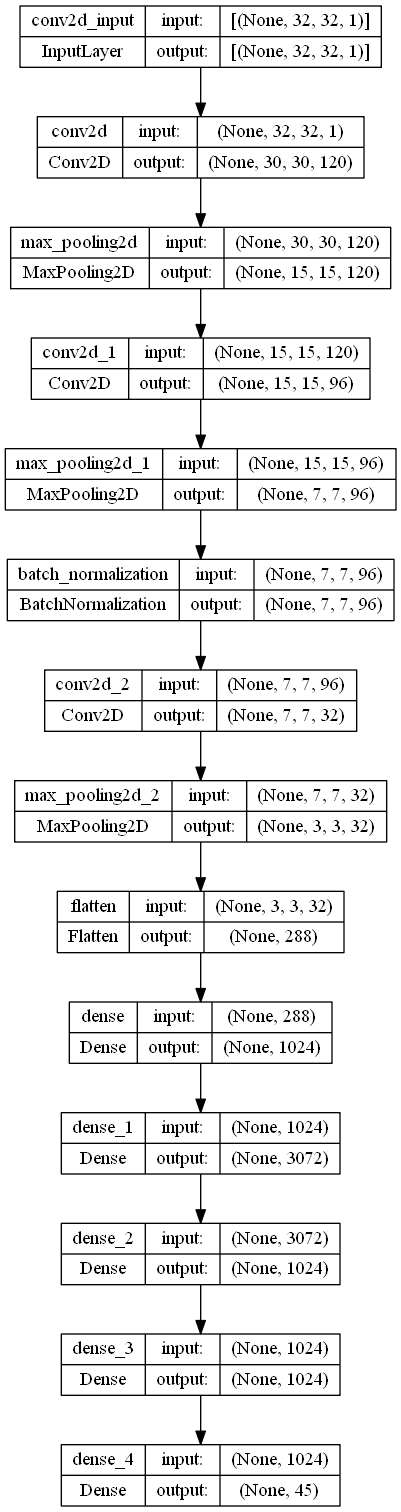

In [ ]:
keras.utils.plot_model(best_model, to_file="best_model.png", show_shapes= True) 

# Retraining models + plotting performances

In [ ]:
import datetime

history = best_model.fit(x_train, y_train, validation_split= 0.2, epochs= 5, batch_size= 64, verbose= 2)

loss, accuracy = best_model.evaluate(x_test, y_test, verbose= 0)

print(f'Test dataset --> Model loss: {np.round(loss, 2)} - model accuracy: {np.round(accuracy * 100, 1)}%')

ct = datetime.datetime.now()

show_history(history)

plot_history(history, path= f'{int(ct.timestamp())}.png')

plt.close()

Epoch 1/5
113/113 - 69s - loss: 0.6720 - accuracy: 0.8051 - val_loss: 1.4036 - val_accuracy: 0.5928 - 69s/epoch - 608ms/step
Epoch 2/5
113/113 - 62s - loss: 0.6136 - accuracy: 0.8278 - val_loss: 1.4465 - val_accuracy: 0.5778 - 62s/epoch - 545ms/step
Epoch 3/5
113/113 - 62s - loss: 0.5640 - accuracy: 0.8376 - val_loss: 1.5860 - val_accuracy: 0.5356 - 62s/epoch - 552ms/step
Epoch 4/5
113/113 - 62s - loss: 0.5061 - accuracy: 0.8575 - val_loss: 1.6296 - val_accuracy: 0.5333 - 62s/epoch - 545ms/step
Epoch 5/5
